In [15]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# * KPI/METRICS



* *KPI/METRICS: Completion Rate: The proportion of users who reach the final ‘confirm’ step.*

In [6]:
merged = pd.read_csv("vanguard_merged.csv")

In [ ]:
# Filter out 'unknown' variation
filtered = merged[merged['variation'].isin(['control', 'test'])]

# Count unique visitor_id per variation
visitor_counts = filtered.groupby('variation')['visitor_id'].nunique()

print(visitor_counts)

# Group by variation and process_step, count unique visitor_id
visitor_counts = filtered.groupby(['variation', 'process_step'])['visitor_id'].nunique()
visitor_counts

variation
control    26252
test       29879
Name: visitor_id, dtype: int64


variation  process_step
control    confirm         15548
           start           25884
           step_1          21210
           step_2          19143
           step_3          17677
test       confirm         19481
           start           28698
           step_1          25519
           step_2          22949
           step_3          21245
Name: visitor_id, dtype: int64

In [8]:
# Keep only 'control' and 'test' variations
subset = merged[merged['variation'].isin(['control', 'test'])]

# Total starters per variation (based on process_step == 'start')
starters = subset[subset['process_step'] == 'start'].groupby('variation')['visitor_id'].nunique()

# Total completions per variation (based on process_step == 'confirm')
completions = subset[subset['process_step'] == 'confirm'].groupby('variation')['visitor_id'].nunique()

# Calculate completion rate as percentage
completion_rate = (completions / starters * 100).round(2)

print("Completion Rate by Variation (%):")
print(completion_rate)


Completion Rate by Variation (%):
variation
control    60.07
test       67.88
Name: visitor_id, dtype: float64


the new design has a completion rate of 67.9%, which is an increase of 7,8% percentage points over the control group. It is a clear improvement in user flow efficiency.

In [10]:


# Completion rate data
variations = ['Control', 'Test']
completion_rates = [60.08, 67.88]

# Create bar chart
fig = go.Figure(data=[
    go.Bar(
        x=variations,
        y=completion_rates,
        text=[f'{rate:.1f}%' for rate in completion_rates],
        textposition='auto',
        marker_color=['white', 'lightseagreen']  # Custom bar colors
    )
])

# Update layout with deep gray background and white text
fig.update_layout(
    title='Completion Rate',
    xaxis_title='Variation Group',
    yaxis_title='Completion Rate (%)',
    yaxis=dict(range=[0, 100], color='white'),
    xaxis=dict(color='white'),
    plot_bgcolor='#1a1a1a',
    paper_bgcolor='#1a1a1a',
    font=dict(color='white'),
    bargap=0.3
)

fig.show()


Step counts by variation:
process_step  confirm  start  step_1  step_2  step_3
variation                                           
control         17315  45320   29505   25742   22476
test            25571  55707   38619   30865   25733

Step percentages by variation:
process_step  confirm  start  step_1  step_2  step_3
variation                                           
control         12.34  32.29   21.02   18.34   16.01
test            14.49  31.56   21.88   17.49   14.58


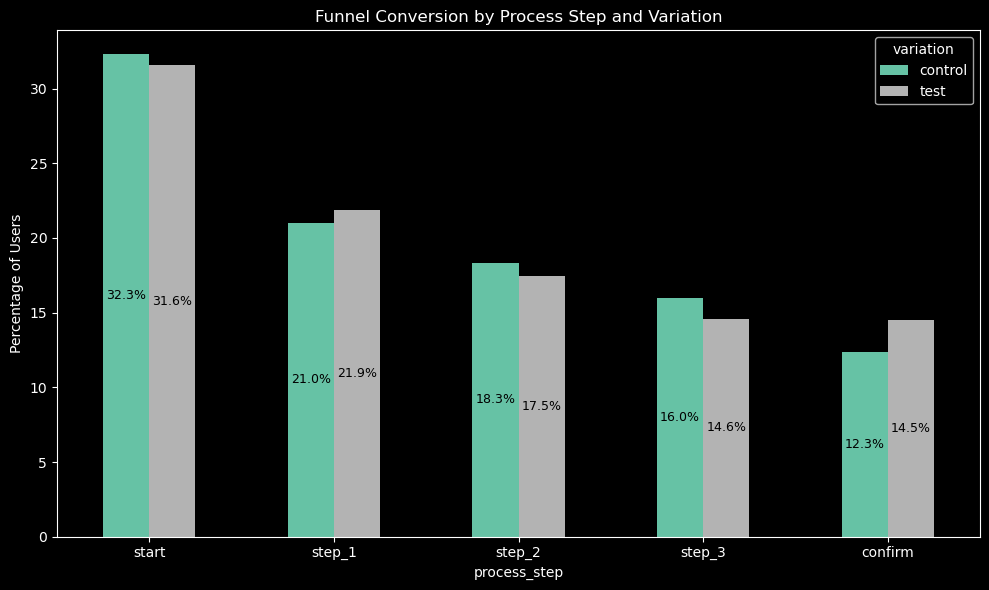

In [ ]:
#Funnel Conversion by Process Step and Variation


# Filter out the 'unknown' variation group
filtered = merged[merged['variation'].isin(['control', 'test'])]

# Group and count number of people per process_step for each variation
step_counts_by_variation = filtered.groupby(['variation', 'process_step']).size().unstack()

# Display the raw counts
print("Step counts by variation:")
print(step_counts_by_variation)

# Normalize counts to percentages per variation group (row-wise)
step_percent_by_variation = step_counts_by_variation.div(step_counts_by_variation.sum(axis=1), axis=0) * 100

# Display result (rounded for neatness)
print("\nStep percentages by variation:")
print(step_percent_by_variation.round(2))

# Reorder steps for consistent plotting (if all steps exist in the data)
step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
available_steps = [step for step in step_order if step in step_percent_by_variation.columns]
step_percent_ordered = step_percent_by_variation[available_steps]


# Create the bar plot
ax = step_percent_ordered.T.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.ylabel('Percentage of Users')
plt.title('Funnel Conversion by Process Step and Variation')
plt.xticks(rotation=0)
plt.tight_layout()

# Annotate percentages on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', color='black', fontsize=9)

plt.show()



Switched to group percentages rather than raw counts to compare behaviours accross variations (control, test).
While the "start step" had a higher percentage of visitors for the control group, the test group had the higher percentage of visitors reached the "confirm step"

* *KPI/METRICS: Time Spent on Each Step: The average duration users spend on each step.*

In [11]:
#Average Time per Step Duration



# Ensure datetime format
merged['date_time'] = pd.to_datetime(merged['date_time'])

# Filter out rows with unknown variation
merged = merged[merged['variation'].str.lower() != 'unknown']

# Sort data
merged_sorted = merged.sort_values(by=['visitor_id', 'date_time'])

# Calculate time spent between steps per visitor
merged_sorted['step_duration'] = merged_sorted.groupby('visitor_id')['date_time'].diff().dt.total_seconds()

# Drop NaNs (first steps)
step_durations = merged_sorted.dropna(subset=['step_duration'])

# Group by variation (test/control) and process step
average_time_per_step = (
    step_durations
    .groupby(['variation', 'process_step'])['step_duration']
    .mean() / 60  # Convert to minutes
)

# Round and print
print(average_time_per_step.round(2))



variation  process_step
control    confirm          805.12
           start           4706.99
           step_1            14.57
           step_2             0.66
           step_3             5.86
test       confirm         1225.55
           start           3163.52
           step_1            15.90
           step_2             1.40
           step_3             9.32
Name: step_duration, dtype: float64


In [12]:
# we add session cut-off to clean up long durations
#we consider filtering out gaps longer than, say, 30 minutes (or 1 hour):

step_durations = merged_sorted.dropna(subset=['step_duration'])
step_durations = step_durations[step_durations['step_duration'] <= 3600]  # 3600 seconds = 1 hour


In [13]:
average_time_per_step = step_durations.groupby(['variation', 'process_step'])['step_duration'].mean() / 60
print(average_time_per_step.round(2))


variation  process_step
control    confirm         2.16
           start           3.00
           step_1          0.72
           step_2          0.66
           step_3          1.57
test       confirm         2.15
           start           2.61
           step_1          0.64
           step_2          0.82
           step_3          1.63
Name: step_duration, dtype: float64


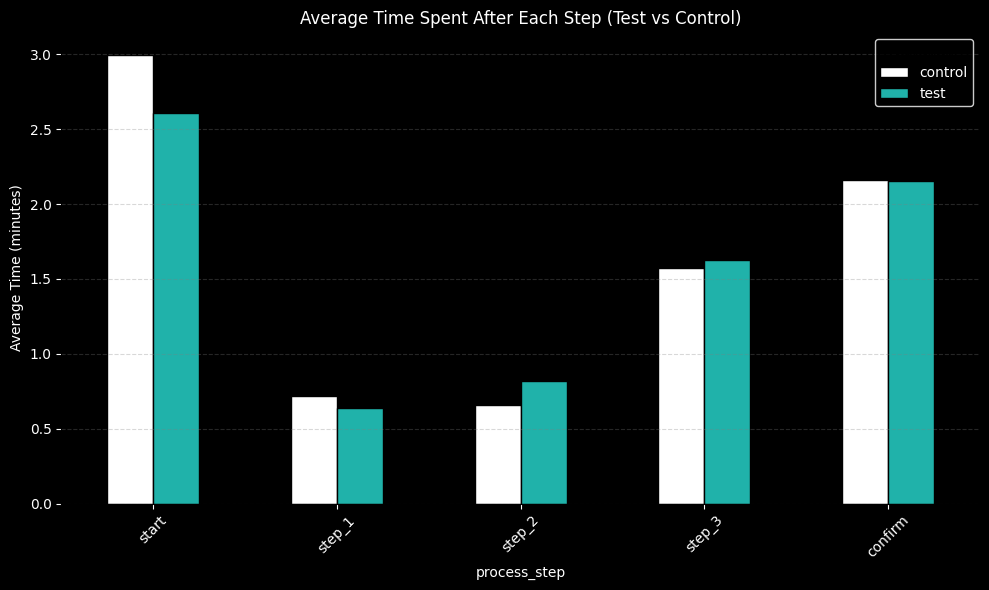

In [40]:
# Reshape the data
bar_data = average_time_per_step.unstack(level=0)

# Move 'confirm' to the end of the index
if 'confirm' in bar_data.index:
    new_order = [step for step in bar_data.index if step != 'confirm'] + ['confirm']
    bar_data = bar_data.loc[new_order]

# Create figure and axes with black background
fig, ax = plt.subplots(figsize=(10, 6), facecolor='black')

# Plot with custom colors: blue for control, green for test
bar_data.plot(kind='bar', ax=ax, edgecolor='black', color=['white', 'lightseagreen'])

# Styling
ax.set_facecolor('black')
ax.set_ylabel("Average Time (minutes)", color='white')
ax.set_title("Average Time Spent After Each Step (Test vs Control)", color='white')
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray')
ax.legend(title='Variation', facecolor='black', edgecolor='white', labelcolor='white')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [18]:
enriched_df = merged.merge(
    average_time_per_step,
    how='left',
    on=['variation', 'process_step']
)
enriched_df.to_csv('vanguard_with_avg_step_duration.csv', index=False, encoding='utf-8-sig', sep=';', lineterminator='\n')

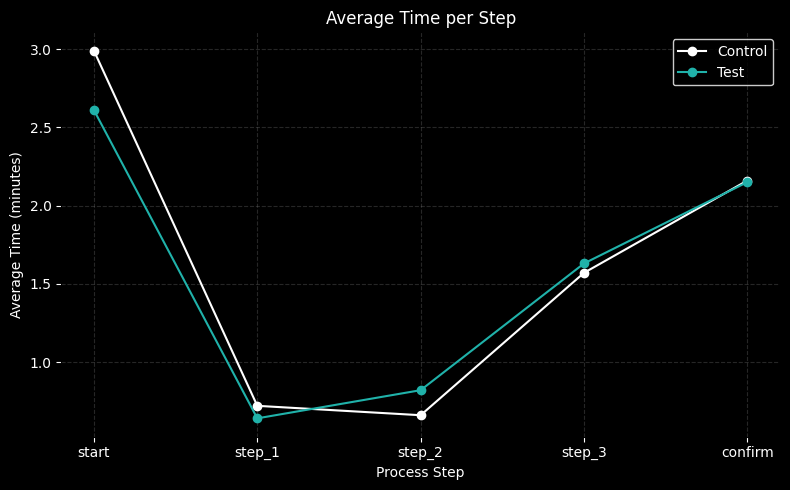

In [ ]:

avg_time_data = {
    'process_step': ['start', 'step_1', 'step_2', 'step_3', 'confirm'],
    'control': [2.99, 0.72, 0.66, 1.57, 2.16],
    'test': [2.61, 0.64, 0.82, 1.63, 2.15]
}
df_time = pd.DataFrame(avg_time_data)

# Figure with black background
fig, ax = plt.subplots(figsize=(8, 5), facecolor='black')

# Plot both series
ax.plot(df_time['process_step'], df_time['control'], marker='o', label='Control', color='white')
ax.plot(df_time['process_step'], df_time['test'], marker='o', label='Test', color='lightseagreen')

# Styling
ax.set_facecolor('black')
ax.set_ylabel('Average Time (minutes)', color='white')
ax.set_xlabel('Process Step', color='white')
ax.set_title('Average Time per Step', color='white')
ax.tick_params(colors='white')
ax.grid(True, linestyle='--', alpha=0.3, color='gray')
ax.legend(facecolor='black', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

It looks like users are spending the most time on the 'start' and 'confirmation' steps, which might suggest friction at the beginning (maybe too much info or distractions?), while the 'step_2' and 'step_3' stages fly by, likely due to simplicity or users rushing through.

We should find out what is slowing people down, especially at the start.


* KPI/METRICS: Error Rates: 

In [26]:
# we assign each process step a numeric order
step_order_num = {
    'start': 0,
    'step_1': 1,
    'step_2': 2,
    'step_3': 3,
    'confirm': 4
}

df = pd.read_csv('vanguard_merged.csv')


df['step_order'] = df['process_step'].map(step_order_num) #Mapping textual process steps to numeric step order


df['previous_step_order'] = df.groupby('visitor_id')['step_order'].shift(1) # For each visitor, we find the previous step visited


df['step_diff'] = df['step_order'] - df['previous_step_order'] # the difference between current and previous step


df['is_error'] = df['step_diff'] < 0 # error if the user went backward in the process


# error rate by step AND variation
error_rate_by_step = (
    df.groupby(['process_step', 'variation'])['is_error']
    .agg(['count', 'mean'])  # count = number of transitions; mean = error rate
    .reset_index()
    .rename(columns={'count': 'nb_passages', 'mean': 'error_rate'})
)
print(error_rate_by_step)


# Pivot table: rows = variation (test/control), columns = step_order
error_rate1 = (
    error_rate_by_step
    .query("variation in ['test', 'control']")  # to display just test and control
    .pivot(index='variation', columns='process_step', values='error_rate')
)


#percentage 
error_rate1 = error_rate1.map(lambda x: f"{round(x * 100, 2)}%")
print(f'\n{error_rate1}')



   process_step variation  nb_passages  error_rate
0       confirm   control        17315    0.000000
1       confirm      test        25571    0.000000
2       confirm   unknown        17156    0.000000
3         start   control        45320    0.576302
4         start      test        55707    0.614662
5         start   unknown        40221    0.599861
6        step_1   control        29505    0.758516
7        step_1      test        38619    0.716772
8        step_1   unknown        27263    0.733595
9        step_2   control        25742    0.825421
10       step_2      test        30865    0.785194
11       step_2   unknown        22566    0.806700
12       step_3   control        22476    0.673029
13       step_3      test        25733    0.709595
14       step_3   unknown        19294    0.694672

process_step confirm   start  step_1  step_2  step_3
variation                                           
control         0.0%  57.63%  75.85%  82.54%   67.3%
test            0.0%  61

In [28]:
# Merge df and error_rate_by_step on 'process_step' and 'variation'
df_merged1 = pd.merge(df, error_rate_by_step, on=['process_step', 'variation'], how='left')

In [29]:

df_merged1.to_csv('vanguard_with_error_rate.csv', index=False, encoding='utf-8-sig', sep=';', lineterminator='\n')


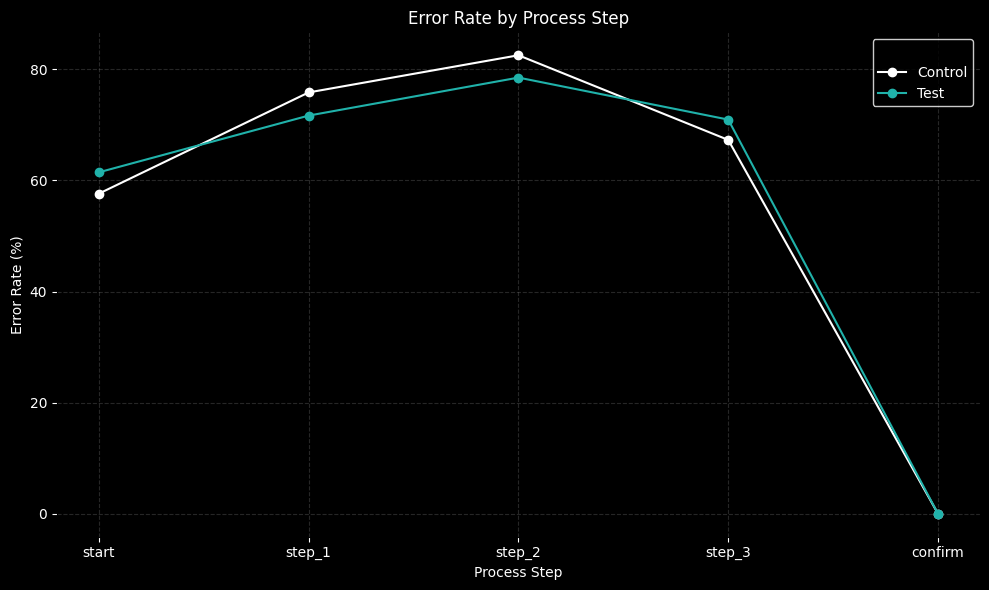

In [34]:
# Convert percentage strings back to float for plotting
error_rate_numeric = error_rate1.map(lambda x: float(x.strip('%')))

# Reorder the columns to match the process flow
ordered_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
error_rate_numeric = error_rate_numeric[ordered_steps]

# Create figure with black background
fig, ax = plt.subplots(figsize=(10, 6), facecolor='black')

# Define custom colors for each variation
variation_colors = {'test': 'lightseagreen', 'control': 'white'}

# Plot each variation with its assigned color
for variation in error_rate_numeric.index:
    color = variation_colors.get(variation, 'gray')  # Default to gray if variation not mapped
    ax.plot(ordered_steps, error_rate_numeric.loc[variation],
            marker='o', label=variation.capitalize(), color=color)

# Styling
ax.set_facecolor('black')
ax.set_title("Error Rate by Process Step", color='white')
ax.set_xlabel("Process Step", color='white')
ax.set_ylabel("Error Rate (%)", color='white')
ax.tick_params(colors='white')
ax.grid(True, linestyle='--', alpha=0.3, color='gray')
ax.legend(title='Variation', facecolor='black', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

Completion Rate
Test (67.9%) > Control (60.1%)
That’s a noteworthy lift—suggests the new design is helping more users reach the finish line. 

Time Spent per Step (Test vs. Control)

Start step: Users in the test group spend ~13% less time (2.61 vs. 2.99 mins). The new design likely streamlines the entry experience.

Step 1 (0.64 vs 0.72)
Step 2 (0.82 vs 0.66)
Step 3 (1.63 vs 1.57)

Confirm step: Users spend one second less (2.15 vs. 2.16 mins). practically the same.

So, quicker to get started, slightly longer decision time later on but overall a quicker process:

Test 7.85 mins.
Control 8.10 mins.



Error Rate

Surprisingly, the test group has higher error rates at ‘start’ (61.47% vs. 57.63%) and step_1 (71.68% vs. 75.85%)


process_step confirm   start  step_1  step_2  step_3
variation                                           
control         0.0%  57.63%  75.85%  82.54%   67.3%
test            0.0%  61.47%  71.68%  78.52%  70.96%

Conclusion:

The new design appears to:

- Increase completions (that’s huge)

- Speed up the entry experience

- Requires UX fine-tuning to minimise backtracking.

More users are finishing faster but there are areas for improvement.


In [42]:
starters

variation
control    25884
test       28698
Name: visitor_id, dtype: int64

In [43]:
completions

variation
control    15548
test       19481
Name: visitor_id, dtype: int64

The information ( starters and competions ) above will be used in the hypothesis testing step